In [1]:
import os
import numpy as np
import logging
np.random.seed(50)
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
logging.getLogger('tensorflow').disabled = True
# machine learning
from keras.preprocessing import image
from keras.models import load_model
from keras.applications.imagenet_utils import preprocess_input, decode_predictions
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import roc_curve, auc, confusion_matrix, ConfusionMatrixDisplay
from numpy import loadtxt
from keras import Model, layers
from keras.applications.mobilenet_v2 import MobileNetV2

import tensorflow as tf
from keras.utils import Sequence
from random import shuffle
from clear_folder import clear_folder
import logging
from split_data import *
# for opening and loading image
import matplotlib.pyplot as plt
# Doing One hot encoding as classifier has multiple classes
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

In [2]:
datapath = '/home/abidhasan/Documents/Indicate_FH/data'
train_dir = '/home/abidhasan/Documents/Indicate_FH/train_val_test/train'
test_dir = '/home/abidhasan/Documents/Indicate_FH/train_val_test/test'
model_dir = '/home/abidhasan/Documents/Indicate_FH/saved_model/'
figpath = '/home/abidhasan/Documents/Indicate_FH/performance_figures'
checkpointpath = '/home/abidhasan/Documents/Indicate_FH/checkpoints/'
batch_size = 16
size = 299
dropout_rt = 0.5
image_size = (size, size)
n_channels = 3
epochs = 100
model_name = 'inceptionv3'
train_data_ratio = 0.8
val_data_ratio = 0.0
test_data_ratio = 0.2

# ModelCheckpoint callback saves a model at some interval.
# File name includes epoch and validation accuracy.


class DataGenerator(Sequence):
    def __init__(self, image_dir, batch_size, image_size, n_channels=3, shuffle=True):
        self.image_dir = image_dir
        self.batch_size = batch_size
        self.image_size = image_size
        self.n_channels = n_channels
        self.shuffle = shuffle
        self.supported_formats = ['.jpg', '.jpeg', '.png', '.gif', '.bmp']
        self.image_files, self.labels = self._load_image_files()
        self.indexes = np.arange(len(self.image_files))
        self.on_epoch_end()

    def __len__(self):
        return int(np.floor(len(self.image_files) / self.batch_size))

    def __getitem__(self, index):
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
        batch_files = [self.image_files[k] for k in indexes]
        batch_labels = [self.labels[k] for k in indexes]

        X = np.empty((self.batch_size, *self.image_size,
                     self.n_channels), dtype=np.float32)
        y = np.empty((self.batch_size), dtype=np.float32)

        for i, file in enumerate(batch_files):
            image = self.load_image(file)
            if image is not None:
                X[i,] = image
                y[i] = batch_labels[i]

        return X, y

    def _load_image_files(self):
        image_files = []
        labels = []
        for label, category in enumerate(['not_effected', 'effected']):
            category_dir = os.path.join(self.image_dir, category)
            for file_name in os.listdir(category_dir):
                if any(file_name.lower().endswith(ext) for ext in self.supported_formats):
                    image_files.append(os.path.join(category_dir, file_name))
                    labels.append(label)
        return image_files, labels

    def load_image(self, image_path):
        try:
            image = tf.io.read_file(image_path)
            image = tf.image.decode_image(image, channels=self.n_channels)
            image = tf.image.resize(image, self.image_size)
            image = image / 255.0
            return image.numpy()
        except:
            # If the image cannot be decoded, return None
            return None

    def on_epoch_end(self):
        if self.shuffle:
            combined = list(zip(self.image_files, self.labels))
            np.random.shuffle(combined)
            self.image_files, self.labels = zip(*combined)

In [3]:
clear_folder('/home/abidhasan/Documents/Indicate_FH/train_val_test')
split_data(datapath, train_data_ratio, val_data_ratio, test_data_ratio)

Contents of '/home/abidhasan/Documents/Indicate_FH/train_val_test' have been cleared.


Copying files: 8915 files [00:00, 9416.51 files/s]


In [4]:
# Function to count images in each class
import os


def count_images(directory):
    affected_count = len(os.listdir(os.path.join(directory, 'effected')))
    not_affected_count = len(os.listdir(
        os.path.join(directory, 'not_effected')))
    return affected_count, not_affected_count


# Count images in train set
train_affected_count, train_not_affected_count = count_images(train_dir)

# Count images in test set
test_affected_count, test_not_affected_count = count_images(test_dir)

# Print the counts
print(
    f'Train set: Affected - {train_affected_count}, Not Affected - {train_not_affected_count}')
print(
    f'Test set: Affected - {test_affected_count}, Not Affected - {test_not_affected_count}')

Train set: Affected - 712, Not Affected - 6420
Test set: Affected - 178, Not Affected - 1605


In [5]:

# Import the inception model
from keras.applications.inception_v3 import InceptionV3

In [6]:
pre_trained_model = InceptionV3(input_shape=(size, size, n_channels),  # Shape of our images
                                include_top=False,  # Leave out the last fully connected layer
                                weights='imagenet')

In [7]:
for layer in pre_trained_model.layers:
  layer.trainable = True
  
x = layers.Flatten()(pre_trained_model.output)
x = layers.Dense(256, activation='relu')(x)
x = layers.Dropout(0.2)(x)
x = layers.Dense(64, activation='relu')(x)
x = layers.Dropout(0.1)(x)
predictions = layers.Dense(1,  activation='sigmoid')(x)
model = Model(pre_trained_model.input, predictions)


model.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adam(
    learning_rate=0.0001), metrics=['accuracy'])

In [8]:
callbacks = [ModelCheckpoint(checkpointpath+model_name+'mdl_wts.hdf5', monitor='val_loss', mode='min', verbose=1, save_best_only=True),
             ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=2, verbose=1, mode='min', min_lr=0.00000001)]

In [9]:

train_gen = DataGenerator(image_dir=train_dir, batch_size=batch_size,
                          image_size=image_size, n_channels=n_channels)
test_gen = DataGenerator(image_dir=test_dir, batch_size=batch_size,
                         image_size=image_size, n_channels=n_channels, shuffle=False)

# Train the model in batches
steps_per_epoch = len(train_gen)
validation_steps = len(test_gen)

print("[INFO] training head...")
history = model.fit(train_gen, epochs=epochs, steps_per_epoch=steps_per_epoch,
                    validation_data=test_gen, validation_steps=validation_steps, callbacks=callbacks)

[INFO] training head...
Epoch 1/100
445/445 [==============================] - ETA: 0s - loss: 0.2334 - accuracy: 0.9272
Epoch 1: val_loss improved from inf to 0.12853, saving model to /home/abidhasan/Documents/Indicate_FH/checkpoints/inceptionv3mdl_wts.hdf5
445/445 [==============================] - 58s 97ms/step - loss: 0.2334 - accuracy: 0.9272 - val_loss: 0.1285 - val_accuracy: 0.9606 - lr: 1.0000e-04
Epoch 2/100
445/445 [==============================] - ETA: 0s - loss: 0.0885 - accuracy: 0.9701
Epoch 2: val_loss improved from 0.12853 to 0.12842, saving model to /home/abidhasan/Documents/Indicate_FH/checkpoints/inceptionv3mdl_wts.hdf5
445/445 [==============================] - 43s 96ms/step - loss: 0.0885 - accuracy: 0.9701 - val_loss: 0.1284 - val_accuracy: 0.9673 - lr: 1.0000e-04
Epoch 3/100
445/445 [==============================] - ETA: 0s - loss: 0.0707 - accuracy: 0.9760
Epoch 3: val_loss did not improve from 0.12842
445/445 [==============================] - 42s 94ms/step -

In [16]:
model = load_model(checkpointpath+model_name+'mdl_wts.hdf5')
model.save(model_dir+model_name+'_'+f"{epochs}"+'.h5')

In [21]:
model = load_model(model_dir+model_name+'_'+f"{epochs}"+'.h5')

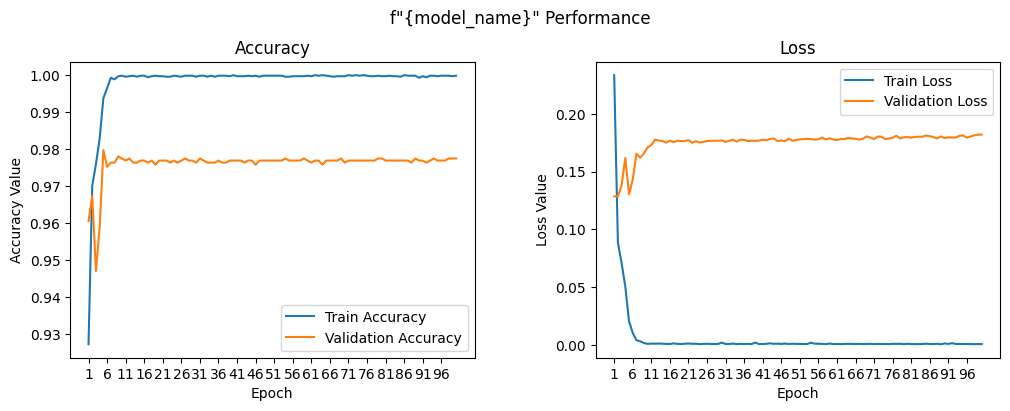

<Figure size 640x480 with 0 Axes>

In [28]:
# Plotting the Model performcaes, train Vs Validation accuracy and train vs Validation Losses.
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
t = f.suptitle('f"{model_name}" Performance', fontsize=12)
f.subplots_adjust(top=0.85, wspace=0.3)
max_epoch = len(history.history['accuracy'])+1
epoch_list = list(range(1, max_epoch))
ax1.plot(epoch_list, history.history['accuracy'], label='Train Accuracy')
ax1.plot(
    epoch_list, history.history['val_accuracy'], label='Validation Accuracy')
ax1.set_xticks(np.arange(1, max_epoch, 5))
ax1.set_ylabel('Accuracy Value')
ax1.set_xlabel('Epoch')
ax1.set_title('Accuracy')
l1 = ax1.legend(loc="best")


ax2.plot(epoch_list, history.history['loss'], label='Train Loss')
ax2.plot(epoch_list, history.history['val_loss'], label='Validation Loss')
ax2.set_xticks(np.arange(1, max_epoch, 5))
ax2.set_ylabel('Loss Value')
ax2.set_xlabel('Epoch')
ax2.set_title('Loss')
l2 = ax2.legend(loc="best")
plt.show()

plt.savefig(figpath+'/'+model_name+'_TRAIN_VS_VALIDATION_LOSS_with_weights.eps', format='eps', bbox_inches='tight')

111/111 [==============================] - 7s 64ms/step - loss: 0.1284 - accuracy: 0.9673
Test accuracy: 96.73%
111/111 [==============================] - 7s 64ms/step


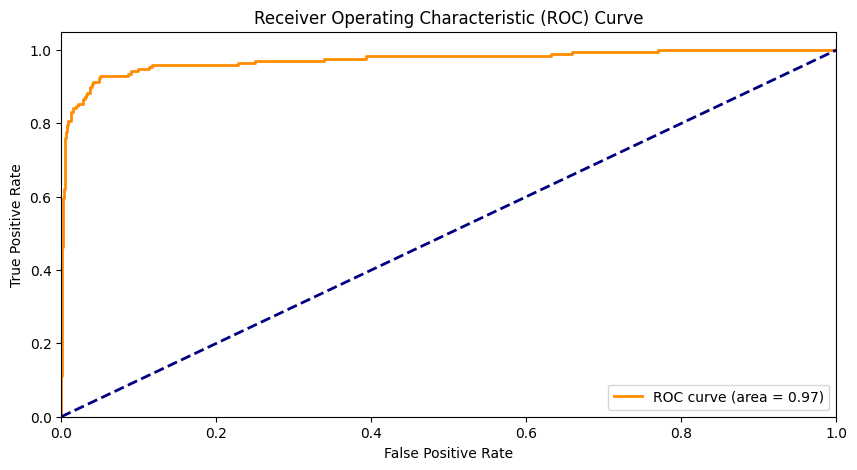

<Figure size 640x480 with 0 Axes>

In [29]:
# Evaluate the model on the test data
loss, accuracy = model.evaluate(test_gen, steps=len(test_gen))
print(f'Test accuracy: {accuracy * 100:.2f}%')

# Get predictions for the test dataset
predictions = model.predict(test_gen, steps=len(test_gen))
predicted_classes = (predictions > 0.5).astype("int32")

# Get true labels and predictions
true_labels = []
for i in range(len(test_gen)):
    _, labels = test_gen[i]
    true_labels.extend(labels)

true_labels = np.array(true_labels)

# Calculate ROC curve and AUC
fpr, tpr, thresholds = roc_curve(true_labels, predictions)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure(figsize=(10, 5))
plt.plot(fpr, tpr, color='darkorange', lw=2,
         label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()
plt.savefig(figpath+'/'+model_name+'_ROC.eps', format='eps', bbox_inches='tight')

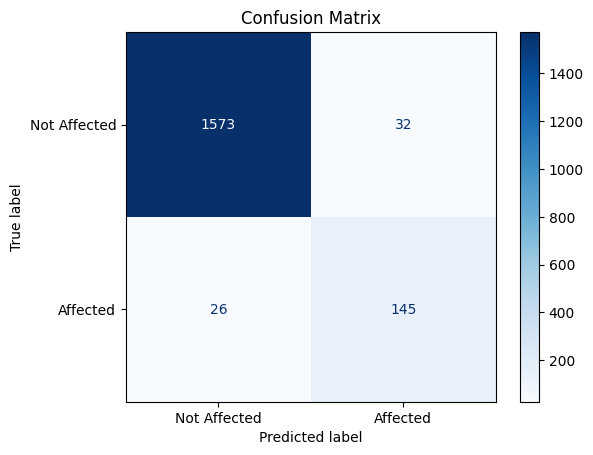

<Figure size 640x480 with 0 Axes>

In [30]:
# Compute the confusion matrix
cm = confusion_matrix(true_labels, predicted_classes)

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[
                              'Not Affected', 'Affected'])
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

plt.savefig(figpath+'/'+model_name+'_CM.eps', format='eps', bbox_inches='tight')

In [31]:
from sklearn.metrics import f1_score

# Assuming true_labels and predicted_classes are your true labels and predicted labels respectively
f1_micro = f1_score(true_labels, predicted_classes, average='micro')
f1_macro = f1_score(true_labels, predicted_classes, average='macro')

print(f"F1 Score (Micro): {f1_micro}")
print(f"F1 Score (Macro): {f1_macro}")

F1 Score (Micro): 0.9673423423423423
F1 Score (Macro): 0.9076154806491885


In [26]:
from sklearn.metrics import precision_recall_fscore_support, confusion_matrix

# Calculate the confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_classes)

# Calculate precision, recall, and F1 score for each class
precisions, recalls, f1s, _ = precision_recall_fscore_support(true_labels, predicted_classes)

# Calculate micro and macro averages
precision_micro = precision_recall_fscore_support(
    true_labels, predicted_classes, average='micro')[0]
recall_micro = precision_recall_fscore_support(
    true_labels, predicted_classes, average='micro')[1]
f1_micro = precision_recall_fscore_support(true_labels, predicted_classes, average='micro')[2]

precision_macro = precision_recall_fscore_support(
    true_labels, predicted_classes, average='macro')[0]
recall_macro = precision_recall_fscore_support(
    true_labels, predicted_classes, average='macro')[1]
f1_macro = precision_recall_fscore_support(true_labels, predicted_classes, average='macro')[2]

# Print the results
print("Per-class precision: ", precisions)
print("Per-class recall: ", recalls)
print("Per-class F1 scores: ", f1s)

print(f"Micro Precision: {precision_micro}")
print(f"Micro Recall: {recall_micro}")
print(f"Micro F1 Score: {f1_micro}")

print(f"Macro Precision: {precision_macro}")
print(f"Macro Recall: {recall_macro}")
print(f"Macro F1 Score: {f1_macro}")

Per-class precision:  [0.98373984 0.81920904]
Per-class recall:  [0.98006231 0.84795322]
Per-class F1 scores:  [0.98189763 0.83333333]
Micro Precision: 0.9673423423423423
Micro Recall: 0.9673423423423423
Micro F1 Score: 0.9673423423423423
Macro Precision: 0.9014744384731983
Macro Recall: 0.9140077608351096
Macro F1 Score: 0.9076154806491885


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


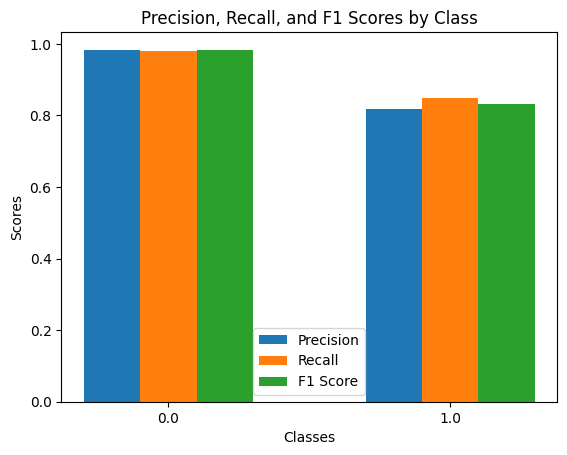

In [27]:
import matplotlib.pyplot as plt
import numpy as np

# Data for plotting
classes = np.unique(true_labels)
x = np.arange(len(classes))

# Plot precision, recall, and F1 scores
fig, ax = plt.subplots()
bar_width = 0.2

ax.bar(x - bar_width, precisions, bar_width, label='Precision')
ax.bar(x, recalls, bar_width, label='Recall')
ax.bar(x + bar_width, f1s, bar_width, label='F1 Score')

# Add some text for labels, title and axes ticks
ax.set_xlabel('Classes')
ax.set_ylabel('Scores')
ax.set_title('Precision, Recall, and F1 Scores by Class')
ax.set_xticks(x)
ax.set_xticklabels(classes)
ax.legend()

# Save plot as EPS file
plt.savefig(figpath+'/'+model_name+'_metrics_plot.eps', format='eps', bbox_inches='tight')
plt.show()

In [15]:
# Get the actual number of affected and not affected images in the test set
actual_affected = sum(true_labels)
actual_not_affected = len(true_labels) - actual_affected

# Get the predicted number of affected and not affected images
predicted_affected = sum(predicted_classes)
predicted_not_affected = len(predicted_classes) - predicted_affected

# Print the counts
print("Actual:")
print(f"Affected: {actual_affected}, Not Affected: {actual_not_affected}")
print("\nPredicted:")
print(
    f"Affected: {predicted_affected}, Not Affected: {predicted_not_affected}")

Actual:
Affected: 171.0, Not Affected: 1605.0

Predicted:
Affected: [177], Not Affected: [1599]
